In [1]:
# Source of data: https://wonder.cdc.gov/controller/datarequest/D153;jsessionid=A591795EE943C0BBA572E5A6D51D45F7

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.linear_model import LinearRegression

In [2]:
# Read in datasets and clean data

cancer_rates = pd.read_csv("Cancer Rates.csv")
cancer_rates_by_race = pd.read_csv("Cancer Rates Race.csv")

for idx, row in cancer_rates.iterrows():
    # drop rows with unreliable data
    if "Unreliable" in row["Mortality-Incidence Age-Adjusted Rate Ratio"]:
        cancer_rates = cancer_rates.drop(idx)

# convert Mortality-Incidence Age-Adjusted Rate Ratio column to floats
cancer_rates["Mortality-Incidence Age-Adjusted Rate Ratio"] = cancer_rates["Mortality-Incidence Age-Adjusted Rate Ratio"].astype('float')
cancer_rates["Year"] = cancer_rates["Year"].astype('int')

In [3]:
# Get list of leading cancer sites and list of years

leading_cancer_sites = []
for idx, row in cancer_rates.iterrows():
    if row["Leading Cancer Sites"] not in leading_cancer_sites:
        leading_cancer_sites.append(row["Leading Cancer Sites"])

years = []
for year in list(cancer_rates["Year"]):
    if year not in years:
        years.append(year)

In [4]:
def sum_statistics_by_site_and_year(df, site, year):
    """ Gets summary statistics for a given cancer site and year
    
    param df: the main dataframe of cancer data
    param site: the leading cancer site to get statistics for
    param year: the year to get statistics for
    return: a dict, where keys = the columns of the DataFrame, and values = the mean of all the rows in each column
    """
    #df = df[df["Leading Cancer Sites"] == site] # filter to only include the cancer site of interest
    df = df[df["Year"] == year] # filter to only include the year of interest
    
    return {"Mortality-Incidence Age-Adjusted Rate Ratio": df.mean()["Mortality-Incidence Age-Adjusted Rate Ratio"]*100,
            "Mortality Age-Adjusted Rate (per 100,000)": df.mean()["Mortality Age-Adjusted Rate (per 100,000)"],
           "Incidence Age-Adjusted Rate (per 100,000)": df.mean()["Incidence Age-Adjusted Rate (per 100,000)"]}

In [5]:
def get_ax():
    """ Creates a matplotlib axis to plot on
    """
    ax = plt.subplot()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    return ax

def plot_year(category):
    d = {}
    for year in list(cancer_rates["Year"]):
        d.update({str(year):sum_statistics_by_site_and_year(cancer_rates, category, year)})
    df = pd.DataFrame(d).T
    ax = get_ax()
    df.plot(ax=ax)

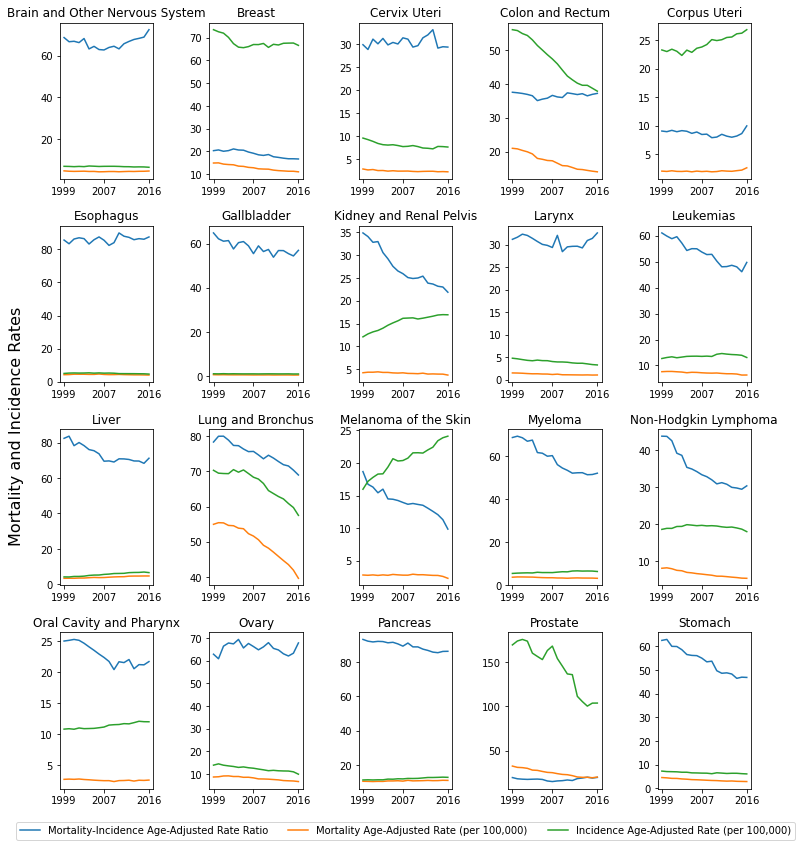

In [6]:
# Plot cancer statistics over time, for each leading cancer site

fig, ax = plt.subplots(4, 5)

categories = 0 # track position in the leading_cancer_sites list
rows = 0 # track row of subplot

while rows <= 3:
    columns = 0 # track column of subplot
    while columns <= 4:
        filtered_df_by_site = cancer_rates[cancer_rates["Leading Cancer Sites"] == leading_cancer_sites[categories]]

        d = {} # key = year, value = dict (where keys = cancer statistic columns and values = means for each statistic for that year)
        for year in years:
            # get cancer statistics for the site and year and add to dictionary
            d.update({year:sum_statistics_by_site_and_year(filtered_df_by_site, leading_cancer_sites[categories], year)})

        # convert the dictionary to a DataFrame and plot it
        df = pd.DataFrame(d).T
        df.plot(ax=ax[rows][columns], legend=False, title=leading_cancer_sites[categories])
        ax[rows][columns].set_xticks([1999, 2007, 2016])
        # increment counters
        columns += 1
        categories += 1
        
        # track progress, as this cell takes a long time to run
    rows += 1

fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-3].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3) # try to make one legend for the entire figure
fig.set_size_inches(12,14)
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.14, wspace=0.6, hspace=0.3)
fig.text(0.05,0.5, "Mortality and Incidence Rates", ha="center", va="center", fontsize=16, rotation=90)
fig.savefig("cancer_rates_over_time.png")
plt.show("off")

In [7]:
# Load and clean up funding data

funding_data = pd.read_csv("Funding Data.csv")

for index, row in funding_data.iterrows():
    for col in funding_data.columns:
        if funding_data.at[index, col] == "*" or funding_data.at[index, col] == "**" or funding_data.at[index, col] == "---":
            funding_data.at[index, col] = np.nan

for col in funding_data.columns[1:]:
    funding_data[col] = funding_data[col].astype("float")

funding_data.head()

,Cancer,Incidence,Mort.,US Gov't YLL (thousands),WHO DALY (thousands),Medicare Spend$ (millions),National spend $ (billions),Lost prod. (billions),NCI Funding (millions),AYLL,YLLPI
0,Bladder,70530.0,14680.0,154.4,128.7,1023.0,3.466,1.977,22.6,10.52,2.19
1,"Brain, ONS",22020.0,13140.0,290.8,NaN,293.0,3.715,5.851,193.1,22.13,13.21
2,Breast,209060.0,40230.0,761.3,612.5,1375.0,13.886,10.879,631.2,18.92,3.64
3,Cervix,12200.0,4210.0,104.7,114.1,73.0,1.425,1.808,76.5,24.87,8.58
4,Colon/rectum,142570.0,51370.0,764.6,542.1,3101.0,12.155,12.802,270.4,14.88,5.36


In [15]:
# Calculate linear regressions

def plot_regressions(df, x, y, ax, color):
    df = df.dropna()
    r = LinearRegression()
    r.fit(df[x].values.reshape(-1,1),
      df[y].values.reshape(-1,1))
    slope = (r.coef_)[0][0]
    intercept = (r.intercept_)[0]
    y0 = (ax.get_xlim()[0])*slope + intercept
    y1 = (ax.get_xlim()[1])*slope + intercept
    ax.plot((ax.get_xlim()[0], ax.get_xlim()[1]), (y0, y1), c=color, dashes=[5,2,1,2])

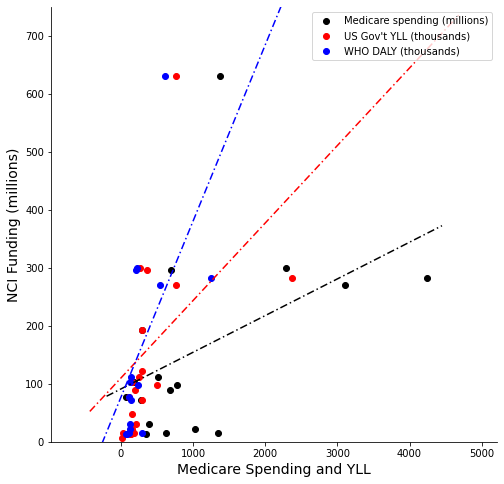

In [16]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(funding_data["Medicare Spend$ (millions)"], funding_data["NCI Funding (millions)"], c="black", label="Medicare spending (millions)")
ax.scatter(funding_data["US Gov't YLL (thousands)"], funding_data["NCI Funding (millions)"], c="red", label="US Gov't YLL (thousands)")
ax.scatter(funding_data["WHO DALY (thousands)"], funding_data["NCI Funding (millions)"], c="blue", label="WHO DALY (thousands)")
ax.set_xlabel("Medicare Spending and YLL", fontsize=14)
ax.set_ylabel("NCI Funding (millions)", fontsize=14)
ax.set_ylim([0,750])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plot_regressions(funding_data, "Medicare Spend$ (millions)", "NCI Funding (millions)", ax=ax, color="black")
plot_regressions(funding_data, "US Gov't YLL (thousands)", "NCI Funding (millions)", ax=ax, color="red")
plot_regressions(funding_data, "WHO DALY (thousands)","NCI Funding (millions)", ax=ax, color="blue")

plt.legend(loc='upper right')
plt.show("off")

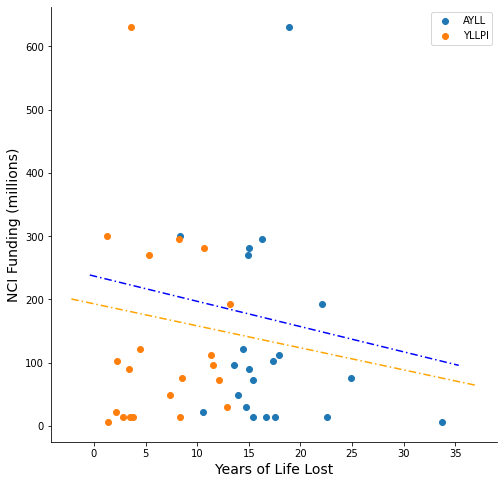

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(funding_data["AYLL"], funding_data["NCI Funding (millions)"], label="AYLL")
ax.scatter(funding_data["YLLPI"], funding_data["NCI Funding (millions)"], label="YLLPI")
ax.set_xlabel("Years of Life Lost", fontsize=14)
ax.set_ylabel("NCI Funding (millions)", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plot_regressions(funding_data, "AYLL", "NCI Funding (millions)", ax=ax, color="blue")
plot_regressions(funding_data, "YLLPI", "NCI Funding (millions)", ax=ax, color="orange")

plt.legend(loc="upper right")
plt.show("off")

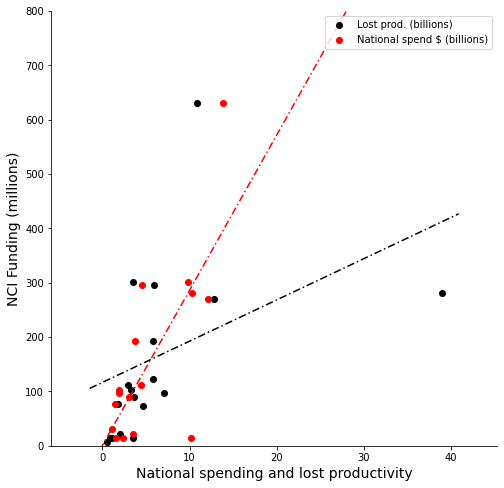

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(funding_data["Lost prod. (billions)"], funding_data["NCI Funding (millions)"], c="black", label="Lost prod. (billions)")
ax.scatter(funding_data["National spend $ (billions)"], funding_data["NCI Funding (millions)"], c="red", label="National spend $ (billions)")
ax.set_xlabel("National spending and lost productivity", fontsize=14)
ax.set_ylabel("NCI Funding (millions)", fontsize=14)
ax.set_ylim([0,800])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plot_regressions(funding_data, "Lost prod. (billions)", "NCI Funding (millions)", ax=ax, color="black")
plot_regressions(funding_data, "National spend $ (billions)", "NCI Funding (millions)", ax=ax, color="red")


plt.legend(loc="upper right")
plt.show("off")